In [1]:
from datasets import load_dataset

billsum = load_dataset("billsum", split="ca_test")

In [2]:
billsum = billsum.train_test_split(test_size=0.2)

In [3]:
billsum["train"][0]

{'text': 'The people of the State of California do enact as follows:\n\n\nSECTION 1.\nSection 8332 of the Government Code is amended to read:\n8332.\nIt is the intent of the Legislature that this chapter does not apply to the Reporting of Improper Governmental Activities Act (Article 3 (commencing with Section 8547) of Chapter 6.5) or the procedures established to investigate civilians’ complaints against peace officers as required by Section 832.5 of the Penal Code.\nSEC. 2.\nSection 148.6 of the Penal Code is amended to read:\n148.6.\n(a) (1) Every person who files any allegation of misconduct against any peace officer, as defined in Chapter 4.5 (commencing with Section 830) of Title 3 of Part 2, knowing the allegation to be false, is guilty of a misdemeanor.\n(2) A law enforcement agency accepting an allegation of misconduct against a peace officer shall require the complainant to read and sign the following advisory, all in boldface type:\nYOU HAVE THE RIGHT TO MAKE A COMPLAINT AGA

In [4]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [5]:
prefix = "summarize: "


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [6]:
tokenized_billsum = billsum.map(preprocess_function, batched=True)

Map:   0%|          | 0/989 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

In [7]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-04-04 23:19:43.438072: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 23:19:43.440249: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 23:19:43.484606: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_V

In [8]:
import evaluate

rouge = evaluate.load("rouge")

In [9]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [10]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [11]:
import intel_extension_for_pytorch as ipex

/home/u0d5d54929dc368d83ffdd3d0dcbf4bf/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set

In [15]:
# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="finetune_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    use_ipex=True,
    
)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_billsum["train"],
    eval_dataset=tokenized_billsum["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,3.064787,0.125200,0.033200,0.104700,0.104600,19.000000


/home/u0d5d54929dc368d83ffdd3d0dcbf4bf/.local/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:469: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(
/home/u0d5d54929dc368d83ffdd3d0dcbf4bf/.local/lib/python3.9/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
2024-04-04 23:30:30,115 - absl - INFO - Using default tokenizer.


TrainOutput(global_step=62, training_loss=3.6800064579133065, metrics={'train_runtime': 527.6207, 'train_samples_per_second': 1.874, 'train_steps_per_second': 0.118, 'total_flos': 267706083311616.0, 'train_loss': 3.6800064579133065, 'epoch': 1.0})

In [16]:
text = "summarize: The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history, which will lift up American workers and create good-paying, union jobs across the country. It'll lower the deficit and ask the ultra-wealthy and corporations to pay their fair share. And no one making under $400,000 per year will pay a penny more in taxes."

In [18]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch import no_grad

# Load your fine-tuned model and tokenizer
model_path = "finetune_model"  # Change this to your model's directory
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

def summarize(text):
    # Encode the text input
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")

    # Generate summary with your model
    with no_grad():
        summary_ids = model.generate(inputs['input_ids'], max_length=150, num_beams=4, early_stopping=True)

    # Decode the generated ids to a text string
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example text
text = "summarize: The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history, which will lift up American workers and create good-paying, union jobs across the country. It'll lower the deficit and ask the ultra-wealthy and corporations to pay their fair share. And no one making under $400,000 per year will pay a penny more in taxes."
# Get the summary
summary = summarize(text)
print(summary)


The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history, which will lift up American workers and create good-paying, union jobs across the country. It will ask the ultra-wealthy and corporations to pay their fair share.


In [35]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import numpy as np
import time

model_checkpoint = "finetune_model"  # Change this to your model's directory
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# Prepare your text
text = "summarize: The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history, which will lift up American workers and create good-paying, union jobs across the country. It'll lower the deficit and ask the ultra-wealthy and corporations to pay their fair share. And no one making under $400,000 per year will pay a penny more in taxes."
inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")

# Ensure model is in evaluation mode
model.eval()

# Check if CUDA (GPU support) is available and use it, otherwise fall back to CPU

model = model.to("cpu")
inputs = inputs.to("cpu")

num_times = 100
warmup_rounds = 20

latency_list = []
for i in range(num_times):
    time_start = time.time()
    with torch.no_grad():
        outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=4, early_stopping=True)
    if i >= warmup_rounds:
        latency_list.append(time.time() - time_start)

fp32_inference_time = np.mean(latency_list)
print(f"Inference time for FP32 took {fp32_inference_time:.3f} seconds")


Inference time for FP32 took 0.655 seconds


In [32]:
model.eval()

model = model.to("cpu")
inputs = inputs.to("cpu")

import time
num_times = 100
warmup_rounds = 20

model = ipex.optimize(model, dtype=torch.bfloat16)
latency_list = []
with torch.no_grad():
    ########################### code changes ########################
    with torch.cpu.amp.autocast(enabled=True, dtype=torch.bfloat16):
    ########################### code changes ########################
        for i in range(num_times):
            time_start = time.time()
            outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=4, early_stopping=True)
            if i >= warmup_rounds:
                latency_list.append(time.time() - time_start)

bf16_inference_time = np.mean(latency_list)
print("Inference time for BF16 took %.3f seconds" %(bf16_inference_time))

Inference time for BF16 took 0.870 seconds


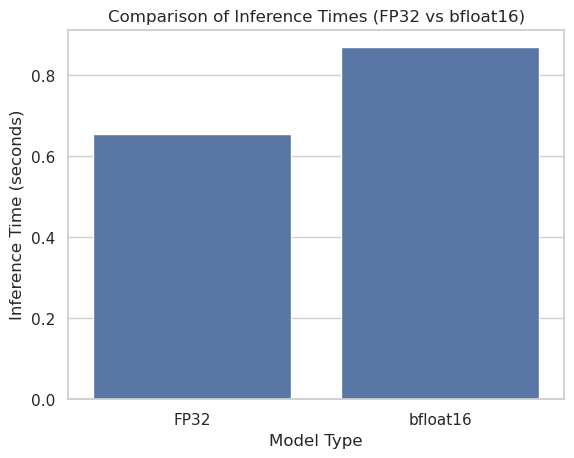

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data for the comparison
data = {'Model Type': ['FP32', 'bfloat16'],
        'Inference Time (seconds)': [fp32_inference_time, bf16_inference_time]}

# Create a Seaborn bar plot to compare the inference times
sns.set(style="whitegrid")
ax = sns.barplot(x='Model Type', y='Inference Time (seconds)', data=data)
ax.set_title('Comparison of Inference Times (FP32 vs bfloat16)')
plt.show()
